In [1]:
import pandas as pd
import numpy as nm
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.linalg import VectorUDT

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
from pyspark.sql.functions import mean, variance
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import random

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
spark = SparkSession.builder.appName("PCA").getOrCreate()
sqlContext = SQLContext(spark)

/storage/home/jjw5989/.local/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
encoded_df = pd.read_csv("./preprocessed_data.csv", low_memory=False,index_col=0)

In [4]:
encoded_df.drop(['Case Number', 'IUCR','Date','Block','FBI Code','Description', "Loc_Descr_Int", "Prim_Type_Int"],axis=1,inplace=True)

In [5]:
feature_columns = encoded_df.columns
feature_columns = list(feature_columns)
feature_columns

['Arrest',
 'Domestic',
 'District',
 'Ward',
 'Community Area',
 'Year',
 'Latitude',
 'Longitude']

In [6]:
df = sqlContext.createDataFrame(encoded_df)

In [7]:
cols_to_cast = ["District","Ward","Community Area","Year","Arrest","Domestic"]
df = df.select([F.col(c).cast('double') if c in cols_to_cast else c for c in df.columns])

In [8]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(df)

In [9]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [10]:
pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

In [11]:
explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

Explained Variance:  0.5616831583611909


In [12]:
result.printSchema()

root
 |-- Arrest: double (nullable = true)
 |-- Domestic: double (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- Year: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pcaFeatures: vector (nullable = true)



In [13]:
def vector_to_array(v):
    return v.toArray().tolist()

In [14]:
vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

In [15]:
result = result.withColumn("pcaFeaturesArray", vector_to_array_udf('pcaFeatures'))

In [16]:
result = result.withColumn('pca1', col('pcaFeaturesArray')[0])
result = result.withColumn('pca2', col('pcaFeaturesArray')[1])

In [17]:
pandas_df = result.select("pca1", "pca2").toPandas()

In [18]:
pandas_df.head(2)

,pca1,pca2
0,-1.563981,0.368321
1,-1.145800,-1.297255


In [19]:
def visualize_PCA(df):
    # Set labels and title
    plt.scatter(pandas_df['pca1'], pandas_df['pca2'])
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")
    plt.title("PCA")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

No handles with labels found to put in legend.


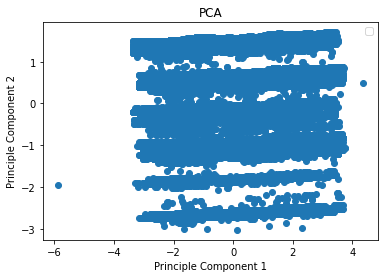

In [20]:
visualize_PCA(pandas_df)